<a href="https://colab.research.google.com/github/RajamannarAanjaram/TSAI-Assignment/blob/master/13%20ViT/CatDogViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 ! pip install -q kaggle
 ! pip install vit-pytorch linformer

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rajamannarak","key":"2e6d8eee890b1b646a19369a0a65e66a"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle competitions download -c 'dogs-vs-cats-redux-kernels-edition'

  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 41.3MB/s]
 98% 533M/544M [00:07<00:00, 88.4MB/s]
100% 544M/544M [00:07<00:00, 72.3MB/s]
100% 270M/271M [00:03<00:00, 88.4MB/s]
100% 271M/271M [00:03<00:00, 88.3MB/s]


In [5]:
ls

kaggle.json  sample_data/  sample_submission.csv  test.zip  train.zip


In [6]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [7]:
from linformer import Linformer   
import glob   
from PIL import Image
from itertools import chain   
from vit_pytorch.efficient import ViT   
from tqdm.notebook import tqdm   
from __future__ import print_function

In [8]:
import torch   
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms   
from torch.optim.lr_scheduler import StepLR   
from torch.utils.data import DataLoader, Dataset

#to unzip the datasets
import zipfile  

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7 #for learning rate scheduler 

In [11]:
os.makedirs('data', exist_ok=True)
train_dir = 'data/train'
test_dir = 'data/test'

In [12]:
#Unzipping dataset
with zipfile.ZipFile('train.zip') as train_zip:
    train_zip.extractall('data')
    
with zipfile.ZipFile('test.zip') as test_zip:
    test_zip.extractall('data')

In [13]:
#Creating train and test list 
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

#printing length of the dataset

print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

Train Data: 25000
Test Data: 12500


In [14]:
train_list[:10]

['data/train/dog.10409.jpg',
 'data/train/cat.3987.jpg',
 'data/train/dog.2223.jpg',
 'data/train/cat.1045.jpg',
 'data/train/dog.354.jpg',
 'data/train/dog.9550.jpg',
 'data/train/dog.5221.jpg',
 'data/train/dog.1740.jpg',
 'data/train/dog.9659.jpg',
 'data/train/dog.1519.jpg']

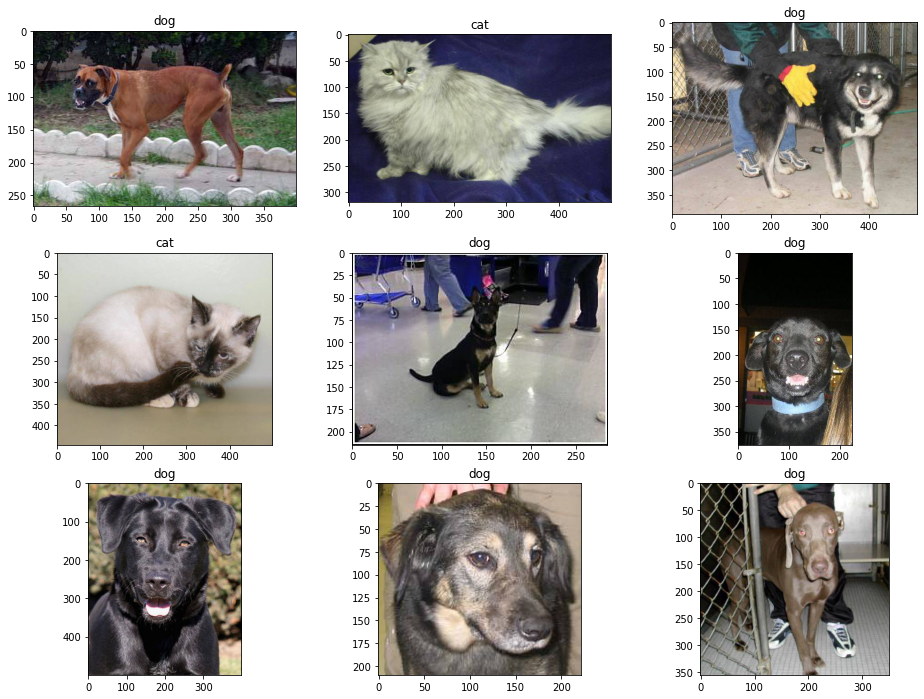

In [20]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [22]:
train_list, valid_list = train_test_split(train_list,
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=40)
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


In [23]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

In [24]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0
        return img_transformed, label

In [25]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [30]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [31]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [33]:
use_cuda = torch.cuda.is_available()
device = 'cuda:0' if use_cuda else 'cpu'

In [40]:
model = ViT(dim=128, image_size=224, patch_size=32,
            num_classes=2, transformer=efficient_transformer,
            channels=3,).to(device)

In [41]:
print(model)

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): Linear(in_features=3072, out_features=128, bias=True)
  )
  (transformer): Linformer(
    (net): SequentialSequence(
      (layers): ModuleList(
        (0): ModuleList(
          (0): PreNorm(
            (fn): LinformerSelfAttention(
              (to_q): Linear(in_features=128, out_features=128, bias=False)
              (to_k): Linear(in_features=128, out_features=128, bias=False)
              (to_v): Linear(in_features=128, out_features=128, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_out): Linear(in_features=128, out_features=128, bias=True)
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (1): PreNorm(
            (fn): FeedForward(
              (w1): Linear(in_features=128, out_features=512, bias=True)
              (act): GELU()
              (dropout)

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [46]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


Epoch : 1 - loss : 0.6979 - acc: 0.5000 - val_loss : 0.6959 - val_acc: 0.5028




Epoch : 2 - loss : 0.6948 - acc: 0.5008 - val_loss : 0.6939 - val_acc: 0.4986




Epoch : 3 - loss : 0.6944 - acc: 0.5028 - val_loss : 0.7073 - val_acc: 0.4972




Epoch : 4 - loss : 0.6939 - acc: 0.5074 - val_loss : 0.6988 - val_acc: 0.5000




Epoch : 5 - loss : 0.6936 - acc: 0.5045 - val_loss : 0.6924 - val_acc: 0.5342




Epoch : 6 - loss : 0.6937 - acc: 0.5076 - val_loss : 0.6936 - val_acc: 0.4990




Epoch : 7 - loss : 0.6928 - acc: 0.5132 - val_loss : 0.6918 - val_acc: 0.5180




Epoch : 8 - loss : 0.6920 - acc: 0.5185 - val_loss : 0.6891 - val_acc: 0.5552




Epoch : 9 - loss : 0.6868 - acc: 0.5451 - val_loss : 0.6836 - val_acc: 0.5576




Epoch : 10 - loss : 0.6798 - acc: 0.5627 - val_loss : 0.6721 - val_acc: 0.5809




Epoch : 11 - loss : 0.6746 - acc: 0.5775 - val_loss : 0.6724 - val_acc: 0.5799




Epoch : 12 - loss : 0.6724 - acc: 0.5817 - val_loss : 0.6715 - val_acc: 0.5833




Epoch : 13 - loss : 0.6712 - acc: 0.5845 - val_loss : 0.6668 - val_acc: 0.5914




Epoch : 14 - loss : 0.6720 - acc: 0.5811 - val_loss : 0.6684 - val_acc: 0.5833




Epoch : 15 - loss : 0.6678 - acc: 0.5873 - val_loss : 0.6717 - val_acc: 0.5843




Epoch : 16 - loss : 0.6680 - acc: 0.5871 - val_loss : 0.6642 - val_acc: 0.6007




Epoch : 17 - loss : 0.6659 - acc: 0.5924 - val_loss : 0.6662 - val_acc: 0.5926




Epoch : 18 - loss : 0.6637 - acc: 0.5926 - val_loss : 0.6606 - val_acc: 0.6058




Epoch : 19 - loss : 0.6623 - acc: 0.5970 - val_loss : 0.6660 - val_acc: 0.5888




Epoch : 20 - loss : 0.6627 - acc: 0.5955 - val_loss : 0.6616 - val_acc: 0.5896

